<a href="https://colab.research.google.com/github/mangaorphy/Formative2-Malaria-Diagnosis-CNN-Transfer-Learning-Group-5/blob/RESNET50/resnet_CNN50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

## Configuration

In [1]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Importing Libraries

In [2]:
# Import additional libraries for evaluation and visualization
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import json
import gc  # Garbage collection for memory management

In [3]:
# Importing basic libraries
import os
import random
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Importing the Keras/TensorFlow libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

## Prepare DataSet

# Download the data for Malaria cells

In [4]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-01 13:45:10--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.163.189.83, 3.163.189.93, 3.163.189.96, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.163.189.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   243MB/s    in 1.4s    

2025-10-01 13:45:11 (243 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  sample_data


# Define the useful paths for data accessibility

In [5]:
# Define the useful paths for data accessibility (updated for local environment)
base_dir = '/content/cell_images'
parasitized_dir = os.path.join(base_dir, 'Parasitized')
uninfected_dir = os.path.join(base_dir, 'Uninfected')

# Create directories for train/validation/test splits
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print(f"Base directory: {base_dir}")
print(f"Parasitized images directory: {parasitized_dir}")
print(f"Uninfected images directory: {uninfected_dir}")
print(f"Training directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

# Verify data directories exist
print(f"\nParasitized folder exists: {os.path.exists(parasitized_dir)}")
print(f"Uninfected folder exists: {os.path.exists(uninfected_dir)}")

Base directory: /content/cell_images
Parasitized images directory: /content/cell_images/Parasitized
Uninfected images directory: /content/cell_images/Uninfected
Training directory: /content/cell_images/train
Validation directory: /content/cell_images/validation
Test directory: /content/cell_images/test

Parasitized folder exists: True
Uninfected folder exists: True


# Data Exploration: Check dataset statistics

In [6]:
# Data Exploration: Check dataset statistics
print("=== DATASET EXPLORATION ===")

# Count images in each directory
parasitized_files = os.listdir(parasitized_dir)
uninfected_files = os.listdir(uninfected_dir)

# Filter only image files
parasitized_files = [f for f in parasitized_files if f.endswith(('.png', '.jpg', '.jpeg'))]
uninfected_files = [f for f in uninfected_files if f.endswith(('.png', '.jpg', '.jpeg'))]

print(f"Total Parasitized images: {len(parasitized_files)}")
print(f"Total Uninfected images: {len(uninfected_files)}")
print(f"Total images: {len(parasitized_files) + len(uninfected_files)}")
print(f"Dataset is balanced: {len(parasitized_files) == len(uninfected_files)}")

=== DATASET EXPLORATION ===
Total Parasitized images: 13779
Total Uninfected images: 13779
Total images: 27558
Dataset is balanced: True



=== PARASITIZED IMAGES ANALYSIS ===


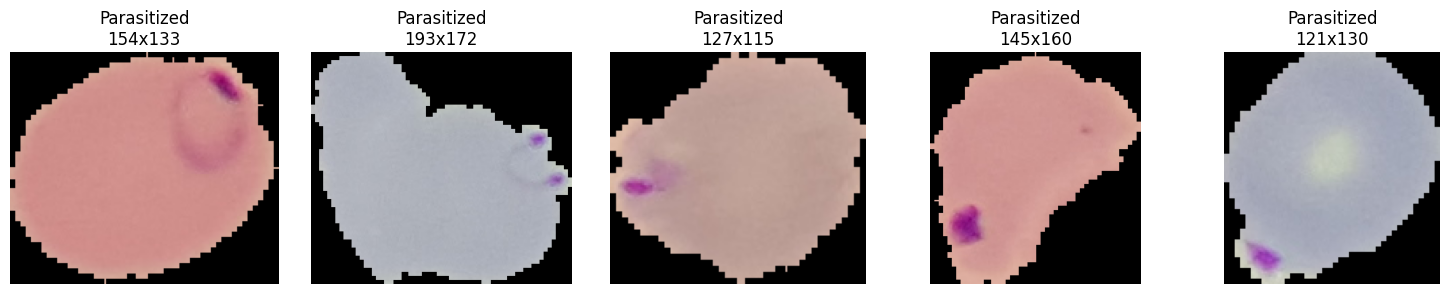

Sample sizes (W x H): [(154, 133), (193, 172), (127, 115), (145, 160), (121, 130)]
Width range: 121 - 193
Height range: 115 - 172

=== UNINFECTED IMAGES ANALYSIS ===


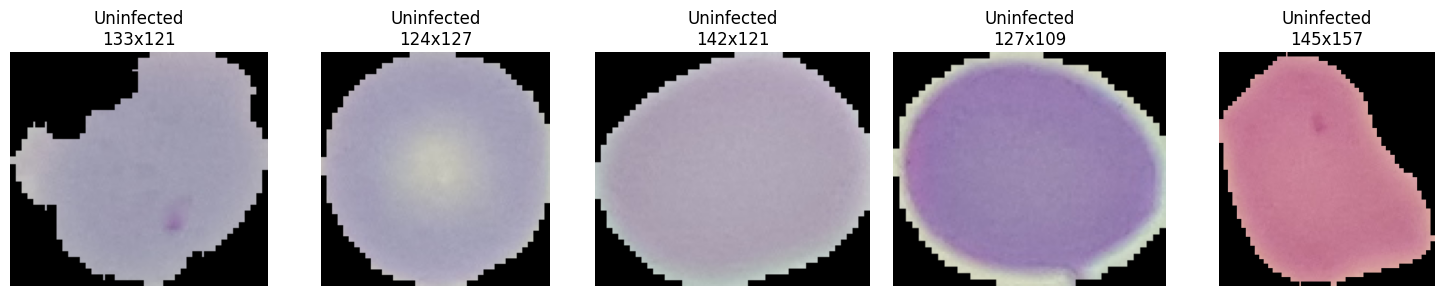

Sample sizes (W x H): [(133, 121), (124, 127), (142, 121), (127, 109), (145, 157)]
Width range: 124 - 145
Height range: 109 - 157


In [7]:
import shutil

# Analyze image properties and display sample images
def analyze_images(directory, class_name, num_samples=5):
    """Analyze image properties and display samples"""
    print(f"\n=== {class_name.upper()} IMAGES ANALYSIS ===")

    files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))][:num_samples]
    sizes = []

    plt.figure(figsize=(15, 3))

    for i, filename in enumerate(files):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        sizes.append(img.size)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f'{class_name}\n{img.size[0]}x{img.size[1]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print size statistics
    widths = [size[0] for size in sizes]
    heights = [size[1] for size in sizes]

    print(f"Sample sizes (W x H): {sizes}")
    print(f"Width range: {min(widths)} - {max(widths)}")
    print(f"Height range: {min(heights)} - {max(heights)}")

    return sizes

# Analyze both classes
parasitized_sizes = analyze_images(parasitized_dir, "Parasitized")
uninfected_sizes = analyze_images(uninfected_dir, "Uninfected")

# Comprehensive image size analysis

Analyzing image dimensions across dataset...

Analyzing all Parasitized image sizes...


Processing Parasitized: 100%|██████████| 1000/1000 [00:00<00:00, 18137.53it/s]



Analyzing all Uninfected image sizes...


Processing Uninfected: 100%|██████████| 1000/1000 [00:00<00:00, 16153.81it/s]


=== IMAGE SIZE STATISTICS ===
Total images analyzed: 2000
Width  - Min: 64, Max: 265, Mean: 132.5
Height - Min: 46, Max: 346, Mean: 133.1


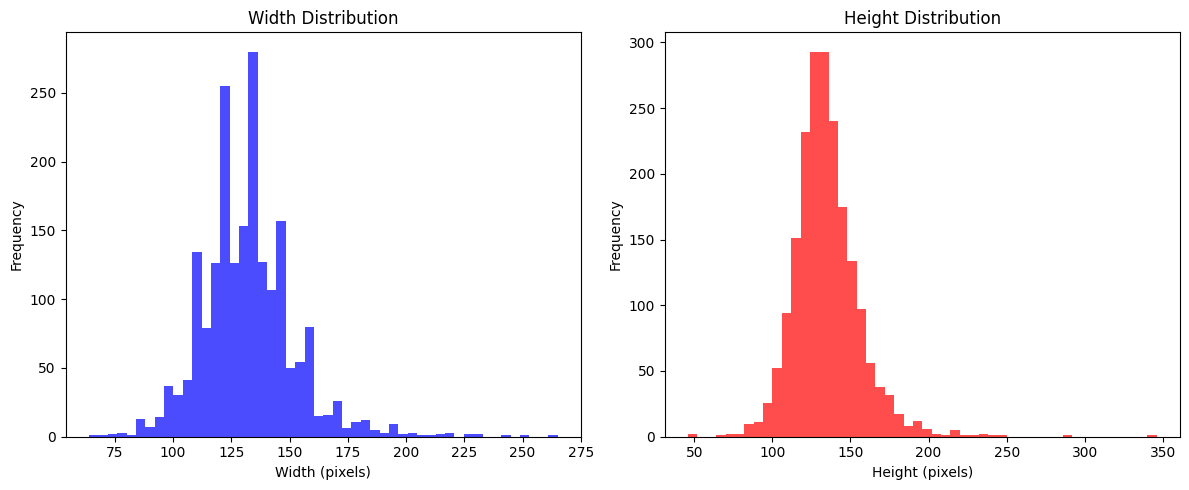

In [8]:
# Comprehensive image size analysis
def get_all_image_sizes(directory, class_name):
    """Get sizes of all images in directory"""
    print(f"\nAnalyzing all {class_name} image sizes...")

    files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    sizes = []

    for filename in tqdm(files[:1000], desc=f"Processing {class_name}"): # Sample first 1000 for speed
        try:
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            sizes.append((img.size[0], img.size[1]))  # (width, height)
            img.close()
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    return sizes

# Analyze image sizes
print("Analyzing image dimensions across dataset...")
parasitized_all_sizes = get_all_image_sizes(parasitized_dir, "Parasitized")
uninfected_all_sizes = get_all_image_sizes(uninfected_dir, "Uninfected")

# Combine and analyze
all_sizes = parasitized_all_sizes + uninfected_all_sizes
widths = [size[0] for size in all_sizes]
heights = [size[1] for size in all_sizes]

print(f"\n=== IMAGE SIZE STATISTICS ===")
print(f"Total images analyzed: {len(all_sizes)}")
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")

# Plot size distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=50, alpha=0.7, color='blue')
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=50, alpha=0.7, color='red')
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Configuration for data preprocessing

In [9]:
# Configuration for data preprocessing
IMG_SIZE = 64  # Standard size for malaria cell images
BATCH_SIZE = 32
TRAIN_SPLIT = 0.7  # 70% for training
VAL_SPLIT = 0.15   # 15% for validation
TEST_SPLIT = 0.15  # 15% for testing

print(f"Image target size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Data splits - Train: {TRAIN_SPLIT*100}%, Val: {VAL_SPLIT*100}%, Test: {TEST_SPLIT*100}%")

# Create directories if they don't exist
def create_directories():
    dirs_to_create = [
        train_dir, val_dir, test_dir,
        os.path.join(train_dir, 'Parasitized'),
        os.path.join(train_dir, 'Uninfected'),
        os.path.join(val_dir, 'Parasitized'),
        os.path.join(val_dir, 'Uninfected'),
        os.path.join(test_dir, 'Parasitized'),
        os.path.join(test_dir, 'Uninfected')
    ]

    for directory in dirs_to_create:
        os.makedirs(directory, exist_ok=True)
        print(f"Created/verified directory: {directory}")

create_directories()

Image target size: 64x64
Batch size: 32
Data splits - Train: 70.0%, Val: 15.0%, Test: 15.0%
Created/verified directory: /content/cell_images/train
Created/verified directory: /content/cell_images/validation
Created/verified directory: /content/cell_images/test
Created/verified directory: /content/cell_images/train/Parasitized
Created/verified directory: /content/cell_images/train/Uninfected
Created/verified directory: /content/cell_images/validation/Parasitized
Created/verified directory: /content/cell_images/validation/Uninfected
Created/verified directory: /content/cell_images/test/Parasitized
Created/verified directory: /content/cell_images/test/Uninfected


## Split data into train/validation/test

In [10]:
# Function to split data into train/validation/test sets
def split_and_copy_data():
    """Split data and copy to respective directories"""

    # Get all image files for each class
    parasitized_files = [f for f in os.listdir(parasitized_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    uninfected_files = [f for f in os.listdir(uninfected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Splitting {len(parasitized_files)} parasitized images...")
    print(f"Splitting {len(uninfected_files)} uninfected images...")

    # Shuffle the files
    parasitized_files = shuffle(parasitized_files, random_state=42)
    uninfected_files = shuffle(uninfected_files, random_state=42)

    def split_files(files, class_name):
        """Split files for a single class"""
        n_total = len(files)
        n_train = int(n_total * TRAIN_SPLIT)
        n_val = int(n_total * VAL_SPLIT)

        train_files = files[:n_train]
        val_files = files[n_train:n_train + n_val]
        test_files = files[n_train + n_val:]

        print(f"{class_name} split: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

        return train_files, val_files, test_files

    # Split files for each class
    para_train, para_val, para_test = split_files(parasitized_files, "Parasitized")
    uninf_train, uninf_val, uninf_test = split_files(uninfected_files, "Uninfected")

    # Copy files to respective directories
    def copy_files(file_list, source_dir, dest_dir, class_name, split_name):
        """Copy files from source to destination"""
        dest_class_dir = os.path.join(dest_dir, class_name)

        for filename in tqdm(file_list, desc=f"Copying {class_name} {split_name}"):
            src_path = os.path.join(source_dir, filename)
            dst_path = os.path.join(dest_class_dir, filename)

            # Only copy if destination doesn't exist
            if not os.path.exists(dst_path):
                shutil.copy2(src_path, dst_path)

    # Copy all files
    copy_files(para_train, parasitized_dir, train_dir, 'Parasitized', 'train')
    copy_files(para_val, parasitized_dir, val_dir, 'Parasitized', 'val')
    copy_files(para_test, parasitized_dir, test_dir, 'Parasitized', 'test')

    copy_files(uninf_train, uninfected_dir, train_dir, 'Uninfected', 'train')
    copy_files(uninf_val, uninfected_dir, val_dir, 'Uninfected', 'val')
    copy_files(uninf_test, uninfected_dir, test_dir, 'Uninfected', 'test')

    print("Data splitting complete!")

    return {
        'train': {'parasitized': len(para_train), 'uninfected': len(uninf_train)},
        'val': {'parasitized': len(para_val), 'uninfected': len(uninf_val)},
        'test': {'parasitized': len(para_test), 'uninfected': len(uninf_test)}
    }

# Execute the splitting (only if directories are empty)
train_para_dir = os.path.join(train_dir, 'Parasitized')
if len(os.listdir(train_para_dir)) == 0:
    print("Performing data split...")
    split_stats = split_and_copy_data()
    print(f"\nFinal split statistics: {split_stats}")
else:
    print("Data already split, skipping...")

Performing data split...
Splitting 13779 parasitized images...
Splitting 13779 uninfected images...
Parasitized split: 9645 train, 2066 val, 2068 test
Uninfected split: 9645 train, 2066 val, 2068 test


Copying Uninfected test: 100%|██████████| 2068/2068 [00:00<00:00, 9644.98it/s]

Data splitting complete!

Final split statistics: {'train': {'parasitized': 9645, 'uninfected': 9645}, 'val': {'parasitized': 2066, 'uninfected': 2066}, 'test': {'parasitized': 2068, 'uninfected': 2068}}


In [11]:
# Data augmentation and preprocessing pipeline setup
print("=== SETTING UP DATA PREPROCESSING PIPELINE ===")

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,              # Normalize pixel values to [0,1]
    rotation_range=20,              # Random rotation
    width_shift_range=0.1,          # Random horizontal shift
    height_shift_range=0.1,         # Random vertical shift
    shear_range=0.1,                # Random shear transformation
    zoom_range=0.1,                 # Random zoom
    horizontal_flip=True,           # Random horizontal flip
    vertical_flip=False,            # No vertical flip (cells have orientation)
    fill_mode='nearest'             # Fill pixels after transformation
)

# Validation and test data (only rescaling, no augmentation)
val_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

print("✓ Data generators configured")
print("  - Training: with augmentation (rotation, shift, shear, zoom, flip)")
print("  - Validation/Test: only normalization")
print(f"  - Target image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - Batch size: {BATCH_SIZE}")

=== SETTING UP DATA PREPROCESSING PIPELINE ===
✓ Data generators configured
  - Training: with augmentation (rotation, shift, shear, zoom, flip)
  - Validation/Test: only normalization
  - Target image size: 64x64
  - Batch size: 32


In [12]:
# Create data generators from directories
print("Creating data generators from directories...")

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,              # Normalize pixel values to [0,1]
    rotation_range=20,              # Random rotation
    width_shift_range=0.1,          # Random horizontal shift
    height_shift_range=0.1,         # Random vertical shift
    shear_range=0.1,                # Random shear transformation
    zoom_range=0.1,                 # Random zoom
    horizontal_flip=True,           # Random horizontal flip
    vertical_flip=False,            # No vertical flip (cells have orientation)
    fill_mode='nearest'             # Fill pixels after transformation
)

# Validation and test data (only rescaling, no augmentation)
val_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)


# Training data generator
train_generator_raw = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',            # Binary classification (0: Parasitized, 1: Uninfected)
    shuffle=True,
    seed=42
)

# Validation data generator
validation_generator_raw = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

# Test data generator
test_generator_raw = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

# Apply prefetch for optimized pipeline
AUTOTUNE = tf.data.AUTOTUNE

train_generator = tf.data.Dataset.from_generator(
    lambda: train_generator_raw,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None])
).prefetch(buffer_size=AUTOTUNE)

validation_generator = tf.data.Dataset.from_generator(
    lambda: validation_generator_raw,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None])
).prefetch(buffer_size=AUTOTUNE)

test_generator = tf.data.Dataset.from_generator(
    lambda: test_generator_raw,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None])
).prefetch(buffer_size=AUTOTUNE)


print(f"\n✓ Data generators created successfully!")
# After converting to tf.data.Dataset, .samples, num_classes, and class_indices attributes are not available
# We will use the raw generators to get these details for printing
print(f"  - Training samples: {train_generator_raw.samples}")
print(f"  - Validation samples: {validation_generator_raw.samples}")
print(f"  - Test samples: {test_generator_raw.samples}")
print(f"  - Number of classes: {train_generator_raw.num_classes}")
print(f"  - Class indices: {train_generator_raw.class_indices}")


# Calculate steps per epoch
STEPS_PER_EPOCH = train_generator_raw.samples // BATCH_SIZE
VALIDATION_STEPS = validation_generator_raw.samples // BATCH_SIZE
TEST_STEPS = test_generator_raw.samples // BATCH_SIZE


print(f"\n✓ Steps per epoch calculated:")
print(f"  - Training steps per epoch: {STEPS_PER_EPOCH}")
print(f"  - Validation steps: {VALIDATION_STEPS}")
print(f"  - Test steps: {TEST_STEPS}")

Creating data generators from directories...
Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead



✓ Data generators created successfully!
  - Training samples: 19290
  - Validation samples: 4132
  - Test samples: 4136
  - Number of classes: 2
  - Class indices: {'Parasitized': 0, 'Uninfected': 1}

✓ Steps per epoch calculated:
  - Training steps per epoch: 602
  - Validation steps: 129
  - Test steps: 129


Visualizing 8 augmented training samples...


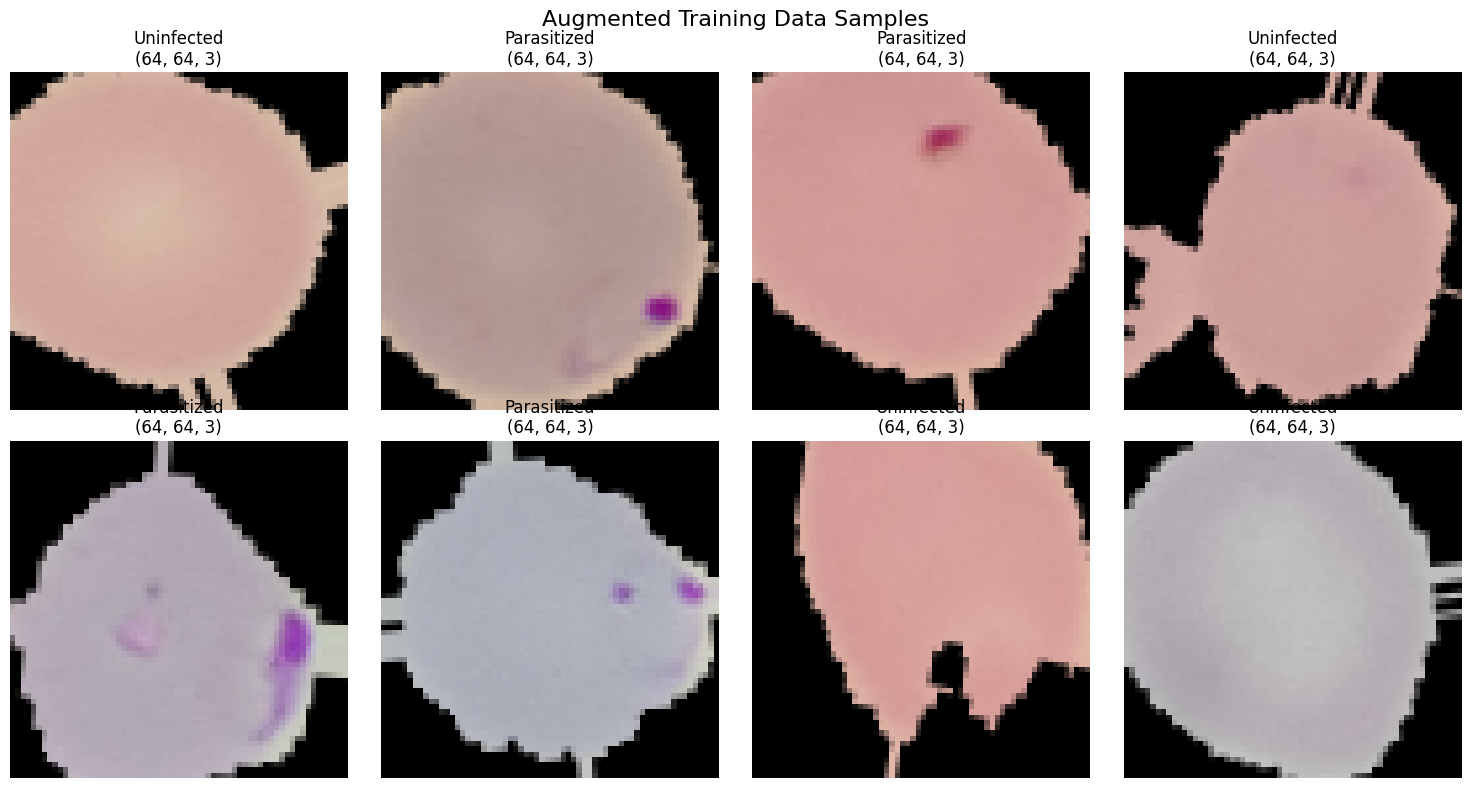

Sample batch shape: (32, 64, 64, 3)
Sample labels shape: (32,)
Pixel value range: [0.000, 0.918]


In [13]:
# Visualize augmented training data samples
def visualize_augmented_data(generator, num_samples=8):
    """Visualize samples from the data generator"""
    print(f"Visualizing {num_samples} augmented training samples...")

    # Get a batch of data by iterating over the dataset and taking one batch
    for sample_batch, sample_labels in generator.take(1):
        # Convert tensors to numpy arrays for visualization
        sample_batch = sample_batch.numpy()
        sample_labels = sample_labels.numpy()

        plt.figure(figsize=(15, 8))
        for i in range(min(num_samples, len(sample_batch))):
            plt.subplot(2, 4, i+1)

            # Display image
            img = sample_batch[i]
            plt.imshow(img)

            # Get class name
            class_name = "Uninfected" if sample_labels[i] == 1 else "Parasitized"
            plt.title(f'{class_name}\n{img.shape}')
            plt.axis('off')

        plt.suptitle('Augmented Training Data Samples', fontsize=16)
        plt.tight_layout()
        plt.show()

        print(f"Sample batch shape: {sample_batch.shape}")
        print(f"Sample labels shape: {sample_labels.shape}")
        print(f"Pixel value range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")

# Visualize training data
visualize_augmented_data(train_generator)

# 🎯 ResNet50 Transfer Learning Experimental Suite

This section implements a comprehensive experimental framework for ResNet50 transfer learning with:

- **7 Different Experiments** with varied hyperparameters
- **Complete Performance Evaluation** (Accuracy, Precision, Recall, F1-Score)
- **Visual Analysis** (Learning Curves, Confusion Matrices, ROC/AUC Curves)
- **Comparative Analysis** across all experiments
- **Best Model Selection** based on performance metrics

## Experimental Design

We will test different combinations of:
- Learning rates (0.001, 0.0005, 0.0001)
- Dropout rates (0.3, 0.5, 0.7)
- Dense layer sizes (128, 256, 512)
- Optimizers (Adam, SGD)
- Fine-tuning strategies (Frozen vs Partially Unfrozen)

In [14]:
# Import ResNet50 and additional libraries for comprehensive evaluation
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import gc
import json

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("✓ Additional libraries imported successfully")
print("✓ Ready to build ResNet50 transfer learning experiments")

✓ Additional libraries imported successfully
✓ Ready to build ResNet50 transfer learning experiments


In [15]:
# Define 7 experimental configurations
experiments = [
    {
        'name': 'Experiment 1: Lower Learning Rate',
        'learning_rate': 0.0005,
        'optimizer': 'adam',
        'dropout_rate': 0.7,
        'dense_neurons': 256,
        'epochs': 25,
        'fine_tune': False,
        'description': 'Reduced learning rate for more stable training and Increased regularization to prevent overfitting'
    },
    {
        'name': 'Experiment 2: Larger Dense Layer',
        'learning_rate': 0.001,
        'optimizer': 'sgd',
        'dropout_rate': 0.5,
        'dense_neurons': 512,
        'epochs': 25,
        'fine_tune': False,
        'description': 'Increased model capacity with more neurons and Alternative optimizer with momentum'
    },
    {
        'name': 'Experiment 3: Fine-tuned ResNet50',
        'learning_rate': 0.0001,
        'optimizer': 'adam',
        'dropout_rate': 0.3,
        'dense_neurons': 256,
        'epochs': 30,
        'fine_tune': True,
        'description': 'Unfrozen top layers for fine-tuning'
    }
]

print(f"✓ Defined {len(experiments)} experimental configurations:")
for i, exp in enumerate(experiments, 1):
    print(f"  {i}. {exp['name']}")
    print(f"     {exp['description']}")

# Global variables to store results
experiment_results = []
all_histories = []

✓ Defined 3 experimental configurations:
  1. Experiment 1: Lower Learning Rate
     Reduced learning rate for more stable training and Increased regularization to prevent overfitting
  2. Experiment 2: Larger Dense Layer
     Increased model capacity with more neurons and Alternative optimizer with momentum
  3. Experiment 3: Fine-tuned ResNet50
     Unfrozen top layers for fine-tuning


In [16]:
# Function to create ResNet50 transfer learning model
def create_resnet_model(config):
    """
    Create a ResNet50 transfer learning model with specified configuration

    Args:
        config: Dictionary containing model configuration parameters

    Returns:
        Compiled Keras model
    """
    print(f"\n Building model: {config['name']}")
    print(f"   Configuration: LR={config['learning_rate']}, Dropout={config['dropout_rate']}, "
          f"Dense={config['dense_neurons']}, Fine-tune={config['fine_tune']}")

    # Clear any previous models from memory
    tf.keras.backend.clear_session()

    # Load pre-trained ResNet50 base
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Configure base model trainability
    if config['fine_tune']:
        # Freeze early layers, allow fine-tuning of later layers
        base_model.trainable = True
        # Freeze the first 100 layers (out of 175 total)
        for layer in base_model.layers[:100]:
            layer.trainable = False
        print(f"   Fine-tuning enabled: {len([l for l in base_model.layers if l.trainable])} trainable layers")
    else:
        # Freeze all layers in base model
        base_model.trainable = False
        print(f"   Base model frozen: {len(base_model.layers)} layers")

    # Build the complete model
    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(config['dense_neurons'], activation='relu'),
        tf.keras.layers.Dropout(config['dropout_rate']),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Configure optimizer
    if config['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=config['learning_rate'],
            momentum=0.9
        )

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(f"   Total parameters: {model.count_params():,}")
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    print(f"   Trainable parameters: {trainable_params:,}")

    return model

print("✓ ResNet50 model creation function defined")

✓ ResNet50 model creation function defined


In [17]:
# Comprehensive model evaluation function
def evaluate_model_comprehensive(model, history, config, exp_number):
    """
    Perform comprehensive evaluation with detailed visualizations and metrics

    Args:
        model: Trained Keras model
        history: Training history object
        config: Experiment configuration
        exp_number: Experiment number for identification

    Returns:
        Dictionary containing all evaluation metrics and results
    """
    print(f"\n{'='*70}")
    print(f"📊 COMPREHENSIVE EVALUATION: {config['name']}")
    print("="*70)

    # Get predictions on test set
    print(" Generating predictions on test set...")
    test_generator_raw.reset()

    # Get true labels and predictions
    y_true = test_generator_raw.classes
    # Use the raw generator directly for prediction and let it determine steps
    y_pred_prob = model.predict(test_generator_raw, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_pred_prob = y_pred_prob.flatten()

    # Calculate comprehensive metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    print(f"📈 PERFORMANCE METRICS:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   ROC-AUC:   {roc_auc:.4f}")

    # Create comprehensive visualization
    create_evaluation_plots(history, cm, fpr, tpr, roc_auc, y_true, y_pred_prob, config, exp_number)

    # Print detailed classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    target_names = ['Parasitized', 'Uninfected']
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

    # Store results
    results = {
        'experiment': config['name'],
        'exp_number': exp_number,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'config': config.copy(),
        'confusion_matrix': cm.tolist(),
        'test_samples': len(y_true),
        'final_train_acc': history.history['accuracy'][-1] if history.history['accuracy'] else None,
        'final_val_acc': history.history['val_accuracy'][-1] if history.history['val_accuracy'] else None,
        'final_train_loss': history.history['loss'][-1] if history.history['loss'] else None,
        'final_val_loss': history.history['val_loss'][-1] if history.history['val_loss'] else None,
        'epochs_trained': len(history.history['loss'])
    }

    return results

def create_evaluation_plots(history, cm, fpr, tpr, roc_auc, y_true, y_pred_prob, config, exp_number):
    """
    Create comprehensive evaluation plots
    """
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(f'{config["name"]} - Comprehensive Model Evaluation', fontsize=16, fontweight='bold', y=0.98)

    # 1. Training History - Loss
    ax1 = plt.subplot(3, 4, 1)
    epochs = range(1, len(history.history['loss']) + 1)
    ax1.plot(epochs, history.history['loss'], 'b-', linewidth=2, label='Training Loss')
    ax1.plot(epochs, history.history['val_loss'], 'r-', linewidth=2, label='Validation Loss')
    ax1.set_title('Model Loss', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add interpretation text
    min_val_loss = min(history.history['val_loss'])
    min_val_epoch = history.history['val_loss'].index(min_val_loss) + 1
    ax1.text(0.05, 0.95, f'Best Val Loss: {min_val_loss:.4f}\nat Epoch: {min_val_epoch}',
             transform=ax1.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 2. Training History - Accuracy
    ax2 = plt.subplot(3, 4, 2)
    ax2.plot(epochs, history.history['accuracy'], 'b-', linewidth=2, label='Training Accuracy')
    ax2.plot(epochs, history.history['val_accuracy'], 'r-', linewidth=2, label='Validation Accuracy')
    ax2.set_title('Model Accuracy', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Add interpretation text
    max_val_acc = max(history.history['val_accuracy'])
    max_acc_epoch = history.history['val_accuracy'].index(max_val_acc) + 1
    ax2.text(0.05, 0.95, f'Best Val Acc: {max_val_acc:.4f}\nat Epoch: {max_acc_epoch}',
             transform=ax2.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    # 3. Confusion Matrix
    ax3 = plt.subplot(3, 4, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=['Parasitized', 'Uninfected'],
                yticklabels=['Parasitized', 'Uninfected'])
    ax3.set_title('Confusion Matrix', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Predicted Label')
    ax3.set_ylabel('True Label')

    # Add performance metrics to confusion matrix
    tn, fp, fn, tp = cm.ravel()
    ax3.text(1.1, 0.5, f'True Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive: {tp}',
             transform=ax3.transAxes, fontsize=9, verticalalignment='center')

    # 4. ROC Curve
    ax4 = plt.subplot(3, 4, 4)
    ax4.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax4.set_xlim([0.0, 1.0])
    ax4.set_ylim([0.0, 1.05])
    ax4.set_xlabel('False Positive Rate')
    ax4.set_ylabel('True Positive Rate')
    ax4.set_title('ROC Curve', fontweight='bold', fontsize=12)
    ax4.legend(loc='lower right')
    ax4.grid(True, alpha=0.3)

    # Add interpretation text
    ax4.text(0.05, 0.95, f'AUC Score: {roc_auc:.4f}\n' +
             ('Excellent' if roc_auc > 0.9 else 'Good' if roc_auc > 0.8 else 'Fair' if roc_auc > 0.7 else 'Poor'),
             transform=ax4.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

    # 5. Prediction Distribution
    ax5 = plt.subplot(3, 4, 5)
    ax5.hist(y_pred_prob[y_true == 0], bins=30, alpha=0.7, label='Parasitized', color='red', density=True)
    ax5.hist(y_pred_prob[y_true == 1], bins=30, alpha=0.7, label='Uninfected', color='blue', density=True)
    ax5.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
    ax5.set_xlabel('Predicted Probability')
    ax5.set_ylabel('Density')
    ax5.set_title('Prediction Probability Distribution', fontweight='bold', fontsize=12)
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Performance Metrics Bar Chart
    ax6 = plt.subplot(3, 4, 6)
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metrics_values = [accuracy_score(y_true, (y_pred_prob > 0.5).astype(int)),
                     precision_score(y_true, (y_pred_prob > 0.5).astype(int)),
                     recall_score(y_true, (y_pred_prob > 0.5).astype(int)),
                     f1_score(y_true, (y_pred_prob > 0.5).astype(int))]

    bars = ax6.bar(metrics_names, metrics_values, color=['skyblue', 'lightgreen', 'orange', 'pink'])
    ax6.set_ylim([0, 1])
    ax6.set_title('Performance Metrics Summary', fontweight='bold', fontsize=12)
    ax6.set_ylabel('Score')

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')

    # 7. Learning Rate Schedule (if available)
    ax7 = plt.subplot(3, 4, 7)
    if 'lr' in history.history:
        ax7.plot(epochs, history.history['lr'], 'g-', linewidth=2)
        ax7.set_title('Learning Rate Schedule', fontweight='bold', fontsize=12)
        ax7.set_xlabel('Epochs')
        ax7.set_ylabel('Learning Rate')
        ax7.set_yscale('log')
    else:
        ax7.text(0.5, 0.5, f'Learning Rate: {config["learning_rate"]}\nOptimizer: {config["optimizer"].upper()}\nDropout: {config["dropout_rate"]}\nDense Neurons: {config["dense_neurons"]}',
                transform=ax7.transAxes, fontsize=11, ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        ax7.set_title('Model Configuration', fontweight='bold', fontsize=12)
        ax7.axis('off')

    # 8. Training Progress Overview
    ax8 = plt.subplot(3, 4, 8)
    final_metrics = {
        'Final Train Acc': history.history['accuracy'][-1] if history.history['accuracy'] else None,
        'Final Val Acc': history.history['val_accuracy'][-1] if history.history['val_accuracy'] else None,
        'Test Accuracy': accuracy_score(y_true, (y_pred_prob > 0.5).astype(int)),
        'ROC-AUC': roc_auc
    }

    y_pos = np.arange(len(final_metrics))
    values = list(final_metrics.values())
    bars = ax8.barh(y_pos, values, color=['blue', 'red', 'green', 'orange'])
    ax8.set_yticks(y_pos)
    ax8.set_yticklabels(final_metrics.keys())
    ax8.set_xlabel('Score')
    ax8.set_title('Final Performance Summary', fontweight='bold', fontsize=12)
    ax8.set_xlim([0, 1])

    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, values)):
        ax8.text(value + 0.01, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', ha='left', va='center', fontweight='bold')

    # 9-12. Additional analysis plots
    # 9. Loss vs Accuracy Correlation
    ax9 = plt.subplot(3, 4, 9)
    ax9.scatter(history.history['loss'], history.history['accuracy'], alpha=0.6, label='Training', s=30)
    ax9.scatter(history.history['val_loss'], history.history['val_accuracy'], alpha=0.6, label='Validation', s=30)
    ax9.set_xlabel('Loss')
    ax9.set_ylabel('Accuracy')
    ax9.set_title('Loss vs Accuracy Relationship', fontweight='bold', fontsize=12)
    ax9.legend()
    ax9.grid(True, alpha=0.3)

    # 10. Overfitting Analysis
    ax10 = plt.subplot(3, 4, 10)
    train_val_gap = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
    ax10.plot(epochs, train_val_gap, 'purple', linewidth=2)
    ax10.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax10.set_title('Overfitting Analysis\n(Train - Val Accuracy)', fontweight='bold', fontsize=12)
    ax10.set_xlabel('Epochs')
    ax10.set_ylabel('Accuracy Gap')
    ax10.grid(True, alpha=0.3)

    # Add interpretation
    avg_gap = np.mean(train_val_gap)
    ax10.text(0.05, 0.95, f'Avg Gap: {avg_gap:.4f}\n' +
             ('Low Overfitting' if avg_gap < 0.05 else 'Moderate Overfitting' if avg_gap < 0.1 else 'High Overfitting'),
             transform=ax10.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

    # 11. Model Convergence
    ax11 = plt.subplot(3, 4, 11)
    loss_change = np.diff(history.history['val_loss'])
    ax11.plot(epochs[1:], loss_change, 'brown', linewidth=2)
    ax11.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax11.set_title('Validation Loss Change\n(Convergence Analysis)', fontweight='bold', fontsize=12)
    ax11.set_xlabel('Epochs')
    ax11.set_ylabel('Loss Change')
    ax11.grid(True, alpha=0.3)

    # 12. Experiment Summary
    ax12 = plt.subplot(3, 4, 12)
    summary_text = f"""
{config['name']}

🎯 Configuration:
• Learning Rate: {config['learning_rate']}
• Optimizer: {config['optimizer'].upper()}
• Dropout: {config['dropout_rate']}
• Dense Neurons: {config['dense_neurons']}
• Fine-tuning: {config['fine_tune']}

📊 Results:
• Test Accuracy: {accuracy_score(y_true, (y_pred_prob > 0.5).astype(int)):.4f}
• F1-Score: {f1_score(y_true, (y_pred_prob > 0.5).astype(int)):.4f}
• ROC-AUC: {roc_auc:.4f}
• Epochs: {len(history.history['loss'])}

💡 Interpretation:
{config['description']}
"""

    ax12.text(0.05, 0.95, summary_text, transform=ax12.transAxes, fontsize=9,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    ax12.axis('off')

    plt.tight_layout()
    plt.show()

    # Print key insights
    print(f"\n💡 KEY INSIGHTS FOR {config['name']}:")
    print(f"   • Model achieved {accuracy_score(y_true, (y_pred_prob > 0.5).astype(int)):.1%} test accuracy")
    print(f"   • {'Low' if avg_gap < 0.05 else 'Moderate' if avg_gap < 0.1 else 'High'} overfitting detected (gap: {avg_gap:.4f})")
    print(f"   • ROC-AUC of {roc_auc:.4f} indicates {'excellent' if roc_auc > 0.9 else 'good' if roc_auc > 0.8 else 'fair'} discrimination")
    print(f"   • Best validation accuracy: {max_val_acc:.4f} at epoch {max_acc_epoch}")


print("✓ Comprehensive evaluation function defined")

✓ Comprehensive evaluation function defined


In [18]:
# Function to run a single experiment
def run_single_experiment(config, exp_number, total_experiments):
    """
    Run a single experiment with comprehensive evaluation

    Args:
        config: Experiment configuration dictionary
        exp_number: Current experiment number
        total_experiments: Total number of experiments

    Returns:
        Dictionary containing experiment results
    """
    print(f"\n {'='*80}")
    print(f"EXPERIMENT {exp_number}/{total_experiments}: {config['name']}")
    print(f"{'='*80}")
    print(f"📝 Description: {config['description']}")
    print(f"⏰ Started at: {datetime.now().strftime('%H:%M:%S')}")

    start_time = datetime.now()

    try:
        # Create model
        model = create_resnet_model(config)

        # Setup callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=8,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7,
                verbose=1
            )
        ]

        print(f"\n Training model for up to {config['epochs']} epochs...")

        # Train model
        history = model.fit(
            train_generator,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=config['epochs'],
            validation_data=validation_generator,
            validation_steps=VALIDATION_STEPS,
            callbacks=callbacks,
            verbose=1
        )

        end_time = datetime.now()
        training_duration = (end_time - start_time).total_seconds() / 60

        print(f"\n✅ Training completed in {training_duration:.2f} minutes")
        print(f"   Final training accuracy: {history.history['accuracy'][-1]:.4f}")
        print(f"   Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
        print(f"   Epochs trained: {len(history.history['loss'])}")

        # Comprehensive evaluation
        results = evaluate_model_comprehensive(model, history, config, exp_number)
        results['training_duration_minutes'] = training_duration

        # Store results and history
        experiment_results.append(results)
        all_histories.append({
            'experiment': config['name'],
            'history': history.history,
            'config': config.copy()
        })

        print(f"\n EXPERIMENT {exp_number} SUMMARY:")
        print(f"   Test Accuracy: {results['accuracy']:.4f}")
        print(f"   F1-Score: {results['f1_score']:.4f}")
        print(f"   ROC-AUC: {results['roc_auc']:.4f}")
        print(f"   Training Time: {training_duration:.2f} minutes")

        # Clean up memory
        del model
        gc.collect()

        return results

    except Exception as e:
        print(f"\n❌ ERROR in {config['name']}: {str(e)}")
        print(f"Skipping to next experiment...")
        return None

print("✓ Single experiment runner function defined")

✓ Single experiment runner function defined


In [19]:
# Visualization and analysis helper functions
def create_final_comparison_plots(df_results):
    """
    Create comprehensive comparison plots across all experiments
    """
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('ResNet50 Transfer Learning - Comprehensive Experimental Comparison', fontsize=16, fontweight='bold')

    # 1. Performance Metrics Comparison
    ax1 = axes[0, 0]
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    x = np.arange(len(df_results))
    width = 0.15

    for i, metric in enumerate(metrics):
        ax1.bar(x + i*width, df_results[metric], width, label=metric.replace('_', '-').title(), alpha=0.8)

    ax1.set_xlabel('Experiments')
    ax1.set_ylabel('Score')
    ax1.set_title('Performance Metrics Comparison', fontweight='bold')
    ax1.set_xticks(x + width*2)
    ax1.set_xticklabels([f'Exp {i+1}' for i in range(len(df_results))], rotation=45)
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # 2. Training Time vs Performance
    ax2 = axes[0, 1]
    scatter = ax2.scatter(df_results['training_duration_minutes'], df_results['f1_score'],
                        c=df_results['accuracy'], s=100, alpha=0.7, cmap='viridis')
    ax2.set_xlabel('Training Time (minutes)')
    ax2.set_ylabel('F1-Score')
    ax2.set_title('Efficiency Analysis\n(Training Time vs Performance)', fontweight='bold')
    plt.colorbar(scatter, ax=ax2, label='Accuracy')

    # Add experiment labels
    for i, row in df_results.iterrows():
        ax2.annotate(f'E{i+1}', (row['training_duration_minutes'], row['f1_score']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    ax2.grid(True, alpha=0.3)

    # 3. Learning Curves Comparison
    ax3 = axes[0, 2]
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_histories)))

    for i, hist_data in enumerate(all_histories):
        history = hist_data['history']
        epochs = range(1, len(history['val_accuracy']) + 1)
        ax3.plot(epochs, history['val_accuracy'], color=colors[i], linewidth=2,
                label=f"Exp {i+1}", alpha=0.8)

    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Validation Accuracy')
    ax3.set_title('Validation Accuracy Convergence', fontweight='bold')
    ax3.legend(fontsize=8, ncol=2)
    ax3.grid(True, alpha=0.3)

    # 4. Hyperparameter Impact - Learning Rate
    ax4 = axes[1, 0]
    lr_groups = df_results.groupby(df_results['config'].apply(lambda x: x['learning_rate']))['f1_score'].agg(['mean', 'std'])
    lr_groups.plot(kind='bar', y='mean', yerr='std', ax=ax4, color='skyblue', alpha=0.7)
    ax4.set_xlabel('Learning Rate')
    ax4.set_ylabel('Average F1-Score')
    ax4.set_title('Learning Rate Impact', fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)

    # 5. Hyperparameter Impact - Dropout Rate
    ax5 = axes[1, 1]
    dropout_groups = df_results.groupby(df_results['config'].apply(lambda x: x['dropout_rate']))['f1_score'].agg(['mean', 'std'])
    dropout_groups.plot(kind='bar', y='mean', yerr='std', ax=ax5, color='lightgreen', alpha=0.7)
    ax5.set_xlabel('Dropout Rate')
    ax5.set_ylabel('Average F1-Score')
    ax5.set_title('Dropout Rate Impact', fontweight='bold')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)

    # 6. Hyperparameter Impact - Dense Neurons
    ax6 = axes[1, 2]
    neurons_groups = df_results.groupby(df_results['config'].apply(lambda x: x['dense_neurons']))['f1_score'].agg(['mean', 'std'])
    neurons_groups.plot(kind='bar', y='mean', yerr='std', ax=ax6, color='orange', alpha=0.7)
    ax6.set_xlabel('Dense Layer Neurons')
    ax6.set_ylabel('Average F1-Score')
    ax6.set_title('Dense Layer Size Impact', fontweight='bold')
    ax6.tick_params(axis='x', rotation=45)
    ax6.grid(True, alpha=0.3)

    # 7. ROC Curves Comparison
    ax7 = axes[2, 0]
    bars = ax7.bar(range(len(df_results)), df_results['roc_auc'], color='purple', alpha=0.7)
    ax7.set_xlabel('Experiments')
    ax7.set_ylabel('ROC-AUC')
    ax7.set_title('ROC-AUC Comparison', fontweight='bold')
    ax7.set_xticks(range(len(df_results)))
    ax7.set_xticklabels([f'Exp {i+1}' for i in range(len(df_results))])

    # Add value labels on bars
    for i, (bar, auc_val) in enumerate(zip(bars, df_results['roc_auc'])):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{auc_val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    ax7.grid(True, alpha=0.3)

    # 8. Overfitting Analysis
    ax8 = axes[2, 1]
    train_val_gaps = []
    for hist_data in all_histories:
        history = hist_data['history']
        final_gap = history['accuracy'][-1] - history['val_accuracy'][-1]
        train_val_gaps.append(final_gap)

    bars = ax8.bar(range(len(train_val_gaps)), train_val_gaps,
                   color=['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green' for gap in train_val_gaps],
                   alpha=0.7)
    ax8.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Moderate Overfitting Threshold')
    ax8.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='High Overfitting Threshold')
    ax8.set_xlabel('Experiments')
    ax8.set_ylabel('Train-Val Accuracy Gap')
    ax8.set_title('Overfitting Analysis', fontweight='bold')
    ax8.set_xticks(range(len(train_val_gaps)))
    ax8.set_xticklabels([f'Exp {i+1}' for i in range(len(train_val_gaps))])
    ax8.legend(fontsize=8)
    ax8.grid(True, alpha=0.3)

    # 9. Performance Summary Heatmap
    ax9 = axes[2, 2]
    heatmap_data = df_results[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].T
    heatmap_data.columns = [f'Exp {i+1}' for i in range(len(df_results))]

    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlBu_r', ax=ax9,
                cbar_kws={'label': 'Score'}, vmin=0.7, vmax=1.0)
    ax9.set_title('Performance Heatmap', fontweight='bold')
    ax9.set_xlabel('Experiments')
    ax9.set_ylabel('Metrics')

    plt.tight_layout()
    plt.show()

def analyze_hyperparameter_impact(df_results):
    """
    Analyze the impact of different hyperparameters
    """
    print(f"\n🔍 HYPERPARAMETER IMPACT ANALYSIS:")
    print("="*60)

    # Learning Rate Analysis
    print(f"\n📊 Learning Rate Impact:")
    lr_analysis = df_results.groupby(df_results['config'].apply(lambda x: x['learning_rate']))['f1_score'].agg(['mean', 'std', 'count'])
    for lr, stats in lr_analysis.iterrows():
        print(f"   LR {lr:>8}: F1={stats['mean']:.4f}±{stats['std']:.4f} (n={int(stats['count'])})")

    # Dropout Rate Analysis
    print(f"\n📊 Dropout Rate Impact:")
    dropout_analysis = df_results.groupby(df_results['config'].apply(lambda x: x['dropout_rate']))['f1_score'].agg(['mean', 'std', 'count'])
    for dr, stats in dropout_analysis.iterrows():
        print(f"   Dropout {dr}: F1={stats['mean']:.4f}±{stats['std']:.4f} (n={int(stats['count'])})")

    # Dense Layer Analysis
    print(f"\n📊 Dense Layer Size Impact:")
    neurons_analysis = df_results.groupby(df_results['config'].apply(lambda x: x['dense_neurons']))['f1_score'].agg(['mean', 'std', 'count'])
    for neurons, stats in neurons_analysis.iterrows():
        print(f"   {neurons} neurons: F1={stats['mean']:.4f}±{stats['std']:.4f} (n={int(stats['count'])})")

    # Optimizer Analysis
    print(f"\n📊 Optimizer Impact:")
    opt_analysis = df_results.groupby(df_results['config'].apply(lambda x: x['optimizer']))['f1_score'].agg(['mean', 'std', 'count'])
    for opt, stats in opt_analysis.iterrows():
        print(f"   {opt.upper():>6}: F1={stats['mean']:.4f}±{stats['std']:.4f} (n={int(stats['count'])})")

    # Fine-tuning Analysis
    print(f"\n📊 Fine-tuning Impact:")
    ft_analysis = df_results.groupby(df_results['config'].apply(lambda x: x['fine_tune']))['f1_score'].agg(['mean', 'std', 'count'])
    for ft, stats in ft_analysis.iterrows():
        ft_label = "Fine-tuned" if ft else "Frozen"
        print(f"   {ft_label:>10}: F1={stats['mean']:.4f}±{stats['std']:.4f} (n={int(stats['count'])})")

def export_results(df_results):
    """
    Export results to CSV and JSON files
    """
    print(f"\n💾 EXPORTING RESULTS:")

    # Export to CSV
    csv_filename = f"resnet50_experiments_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df_export = df_results.copy()
    df_export['config_str'] = df_export['config'].astype(str)
    df_export.drop('config', axis=1).to_csv(csv_filename, index=False)
    print(f"   📄 CSV exported: {csv_filename}")

    # Export detailed results to JSON
    json_filename = f"resnet50_detailed_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    export_data = {
        'experiment_results': experiment_results,
        'all_histories': all_histories,
        'summary_statistics': {
            'mean_accuracy': df_results['accuracy'].mean(),
            'std_accuracy': df_results['accuracy'].std(),
            'mean_f1_score': df_results['f1_score'].mean(),
            'std_f1_score': df_results['f1_score'].std(),
            'best_experiment': df_results.iloc[0]['experiment'],
            'best_f1_score': df_results.iloc[0]['f1_score'],
            'total_experiments': len(df_results),
            'total_training_time': df_results['training_duration_minutes'].sum()
        }
    }

    with open(json_filename, 'w') as f:
        json.dump(export_data, f, indent=2, default=str)
    print(f"   📄 JSON exported: {json_filename}")

    print(f"   ✅ All results successfully exported!")

print("✓ Visualization and analysis helper functions defined")

✓ Visualization and analysis helper functions defined


In [20]:
# MAIN EXPERIMENTAL SUITE FUNCTIONS

# Function to run all experiments and generate comparative analysis
def run_all_experiments():
    """
    Run all 7 experiments sequentially and generate comprehensive comparative analysis
    """
    print(f"\n🎯 STARTING RESNET50 EXPERIMENTAL SUITE")
    print(f"{'='*100}")
    print(f"📊 Total experiments to run: {len(experiments)}")
    print(f"🕐 Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💾 Results will be automatically saved and compared")

    suite_start_time = datetime.now()
    successful_experiments = 0

    # Run each experiment
    for i, config in enumerate(experiments, 1):
        result = run_single_experiment(config, i, len(experiments))
        if result is not None:
            successful_experiments += 1

            # Show intermediate rankings
            if successful_experiments > 1:
                print(f"\n📈 CURRENT RANKINGS (by F1-Score):")
                temp_df = pd.DataFrame(experiment_results).sort_values('f1_score', ascending=False)
                for idx, row in temp_df.head(3).iterrows():
                    print(f"   {idx+1}. {row['experiment']} - F1: {row['f1_score']:.4f}")

        # Estimate remaining time
        if i < len(experiments):
            elapsed = (datetime.now() - suite_start_time).total_seconds() / 60
            estimated_remaining = (elapsed / i) * (len(experiments) - i)
            print(f"\n⏱️  Progress: {i}/{len(experiments)} | Estimated time remaining: {estimated_remaining:.1f} minutes")

    suite_end_time = datetime.now()
    total_duration = (suite_end_time - suite_start_time).total_seconds() / 60

    print(f"\n🎉 EXPERIMENTAL SUITE COMPLETED!")
    print(f"   Total time: {total_duration:.2f} minutes")
    print(f"   Successful experiments: {successful_experiments}/{len(experiments)}")
    if successful_experiments > 0:
        print(f"   Average time per experiment: {total_duration/successful_experiments:.2f} minutes")

    # Generate comprehensive comparative analysis
    if successful_experiments > 0:
        return generate_final_comparative_analysis()
    else:
        print("❌ No successful experiments to analyze.")
        return None

def generate_final_comparative_analysis():
    """
    Generate comprehensive comparative analysis across all experiments
    """
    if not experiment_results:
        print("No experiment results to analyze.")
        return None

    print(f"\n{'='*100}")
    print(f"📊 COMPREHENSIVE COMPARATIVE ANALYSIS")
    print(f"{'='*100}")

    # Create results DataFrame
    df_results = pd.DataFrame(experiment_results)
    df_results = df_results.sort_values('f1_score', ascending=False).reset_index(drop=True)

    # Display performance table
    print(f"\n FINAL PERFORMANCE TABLE (Ranked by F1-Score):")
    print("="*120)

    display_columns = ['experiment', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'training_duration_minutes']
    display_df = df_results[display_columns].copy()
    display_df.columns = ['Experiment', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Time (min)']

    # Format numeric columns
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
    display_df['Time (min)'] = display_df['Time (min)'].apply(lambda x: f"{x:.1f}")

    print(display_df.to_string(index=False))

    # Statistical analysis
    print(f"\n📈 STATISTICAL SUMMARY:")
    print(f"   Mean Accuracy: {df_results['accuracy'].mean():.4f} ± {df_results['accuracy'].std():.4f}")
    print(f"   Mean F1-Score: {df_results['f1_score'].mean():.4f} ± {df_results['f1_score'].std():.4f}")
    print(f"   Mean ROC-AUC: {df_results['roc_auc'].mean():.4f} ± {df_results['roc_auc'].std():.4f}")
    print(f"   Total Training Time: {df_results['training_duration_minutes'].sum():.1f} minutes")

    # Best and worst performers
    best_exp = df_results.iloc[0]
    worst_exp = df_results.iloc[-1]

    print(f"\n🥇 BEST PERFORMER:")
    print(f"   {best_exp['experiment']}")
    print(f"   F1-Score: {best_exp['f1_score']:.4f} | Accuracy: {best_exp['accuracy']:.4f} | ROC-AUC: {best_exp['roc_auc']:.4f}")
    print(f"   Configuration: {best_exp['config']}")

    print(f"\n🥉 LOWEST PERFORMER:")
    print(f"   {worst_exp['experiment']}")
    print(f"   F1-Score: {worst_exp['f1_score']:.4f} | Accuracy: {worst_exp['accuracy']:.4f} | ROC-AUC: {worst_exp['roc_auc']:.4f}")

    # Create comprehensive comparison visualizations
    create_final_comparison_plots(df_results)

    # Hyperparameter analysis
    analyze_hyperparameter_impact(df_results)

    # Export results
    export_results(df_results)

    return df_results

print("✓ Main experimental suite functions defined and ready to use!")
print("📋 To start all experiments, run: final_results = run_all_experiments()")

✓ Main experimental suite functions defined and ready to use!
📋 To start all experiments, run: final_results = run_all_experiments()



🎯 STARTING RESNET50 EXPERIMENTAL SUITE
📊 Total experiments to run: 3
🕐 Started at: 2025-10-01 13:45:25
💾 Results will be automatically saved and compared

EXPERIMENT 1/3: Experiment 1: Lower Learning Rate
📝 Description: Reduced learning rate for more stable training and Increased regularization to prevent overfitting
⏰ Started at: 13:45:25

 Building model: Experiment 1: Lower Learning Rate
   Configuration: LR=0.0005, Dropout=0.7, Dense=256, Fine-tune=False
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
   Base model frozen: 175 layers
   Total parameters: 24,112,513
   Trainable parameters: 524,801

 Training model for up to 25 epochs...
Epoch 1/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 72s 100ms/step - accuracy: 0.5280 - loss: 0.7134 - val_accuracy: 0.6388 - val_loss: 0.6658 - learning_rate: 5.0000e-04
Epoch 2/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 52s 86ms/step - accuracy: 0.5715 - loss: 0.6795 - val_accuracy: 0.6059 - val_loss: 0.6600 - learning_rate: 5.0000e-04
Epoch 3/25
602/602 ━━━━━━━━━━━

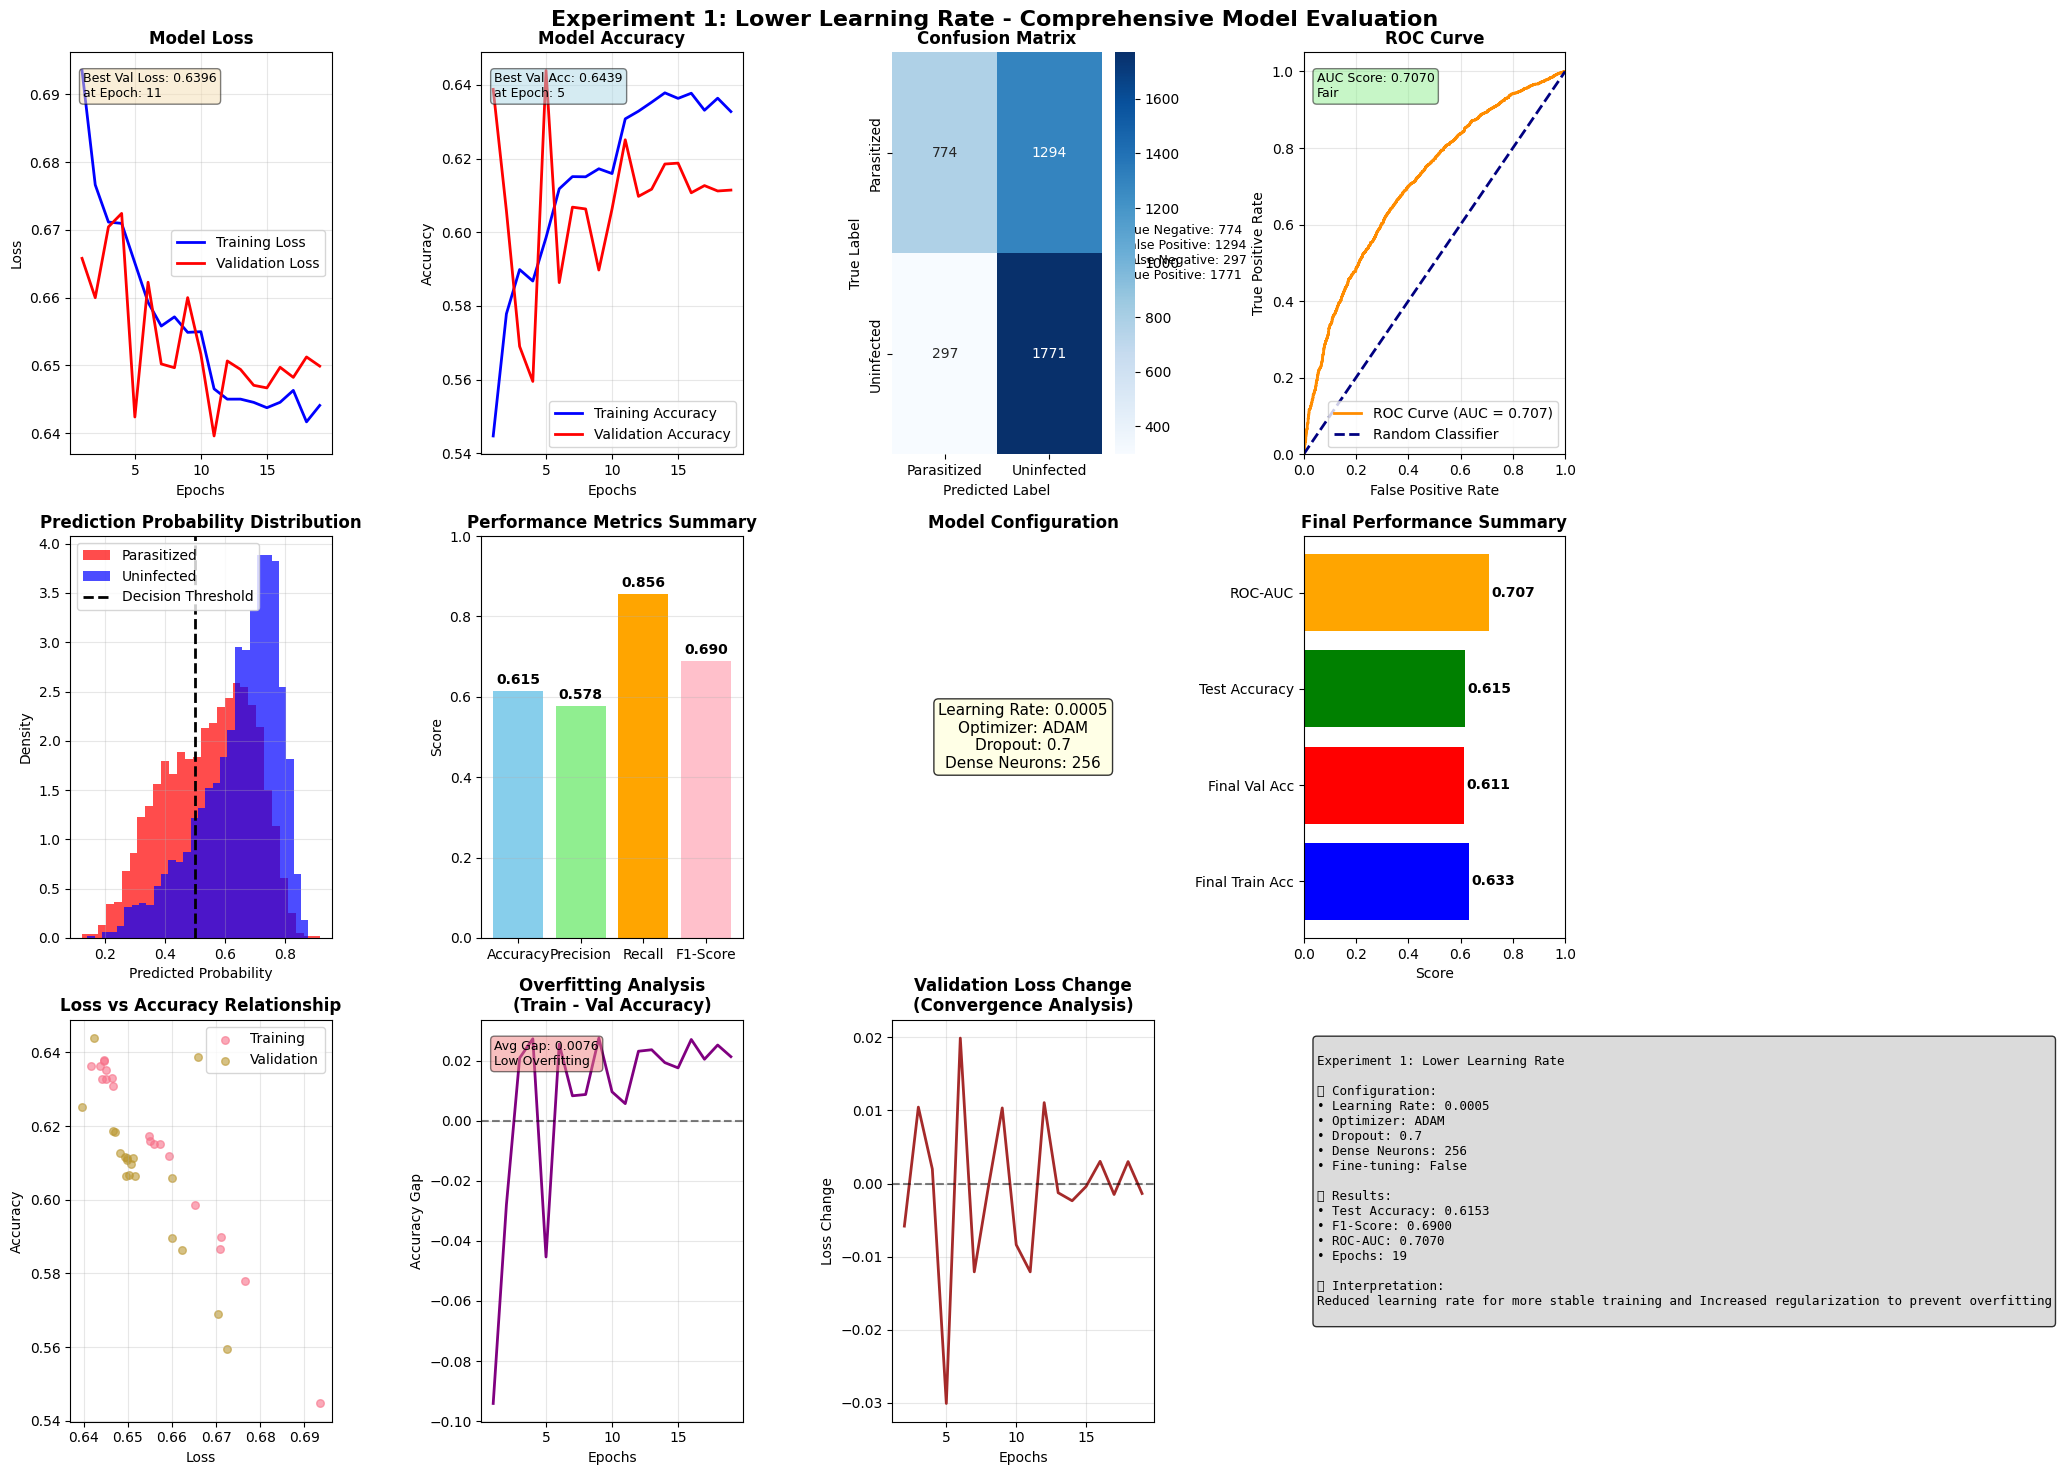


💡 KEY INSIGHTS FOR Experiment 1: Lower Learning Rate:
   • Model achieved 61.5% test accuracy
   • Low overfitting detected (gap: 0.0076)
   • ROC-AUC of 0.7070 indicates fair discrimination
   • Best validation accuracy: 0.6439 at epoch 5

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Parasitized     0.7227    0.3743    0.4932      2068
  Uninfected     0.5778    0.8564    0.6900      2068

    accuracy                         0.6153      4136
   macro avg     0.6503    0.6153    0.5916      4136
weighted avg     0.6503    0.6153    0.5916      4136


 EXPERIMENT 1 SUMMARY:
   Test Accuracy: 0.6153
   F1-Score: 0.6900
   ROC-AUC: 0.7070
   Training Time: 17.53 minutes

⏱️  Progress: 1/3 | Estimated time remaining: 35.6 minutes

EXPERIMENT 2/3: Experiment 2: Larger Dense Layer
📝 Description: Increased model capacity with more neurons and Alternative optimizer with momentum
⏰ Started at: 14:03:12

 Building model: Experiment 2: Larger Dense L

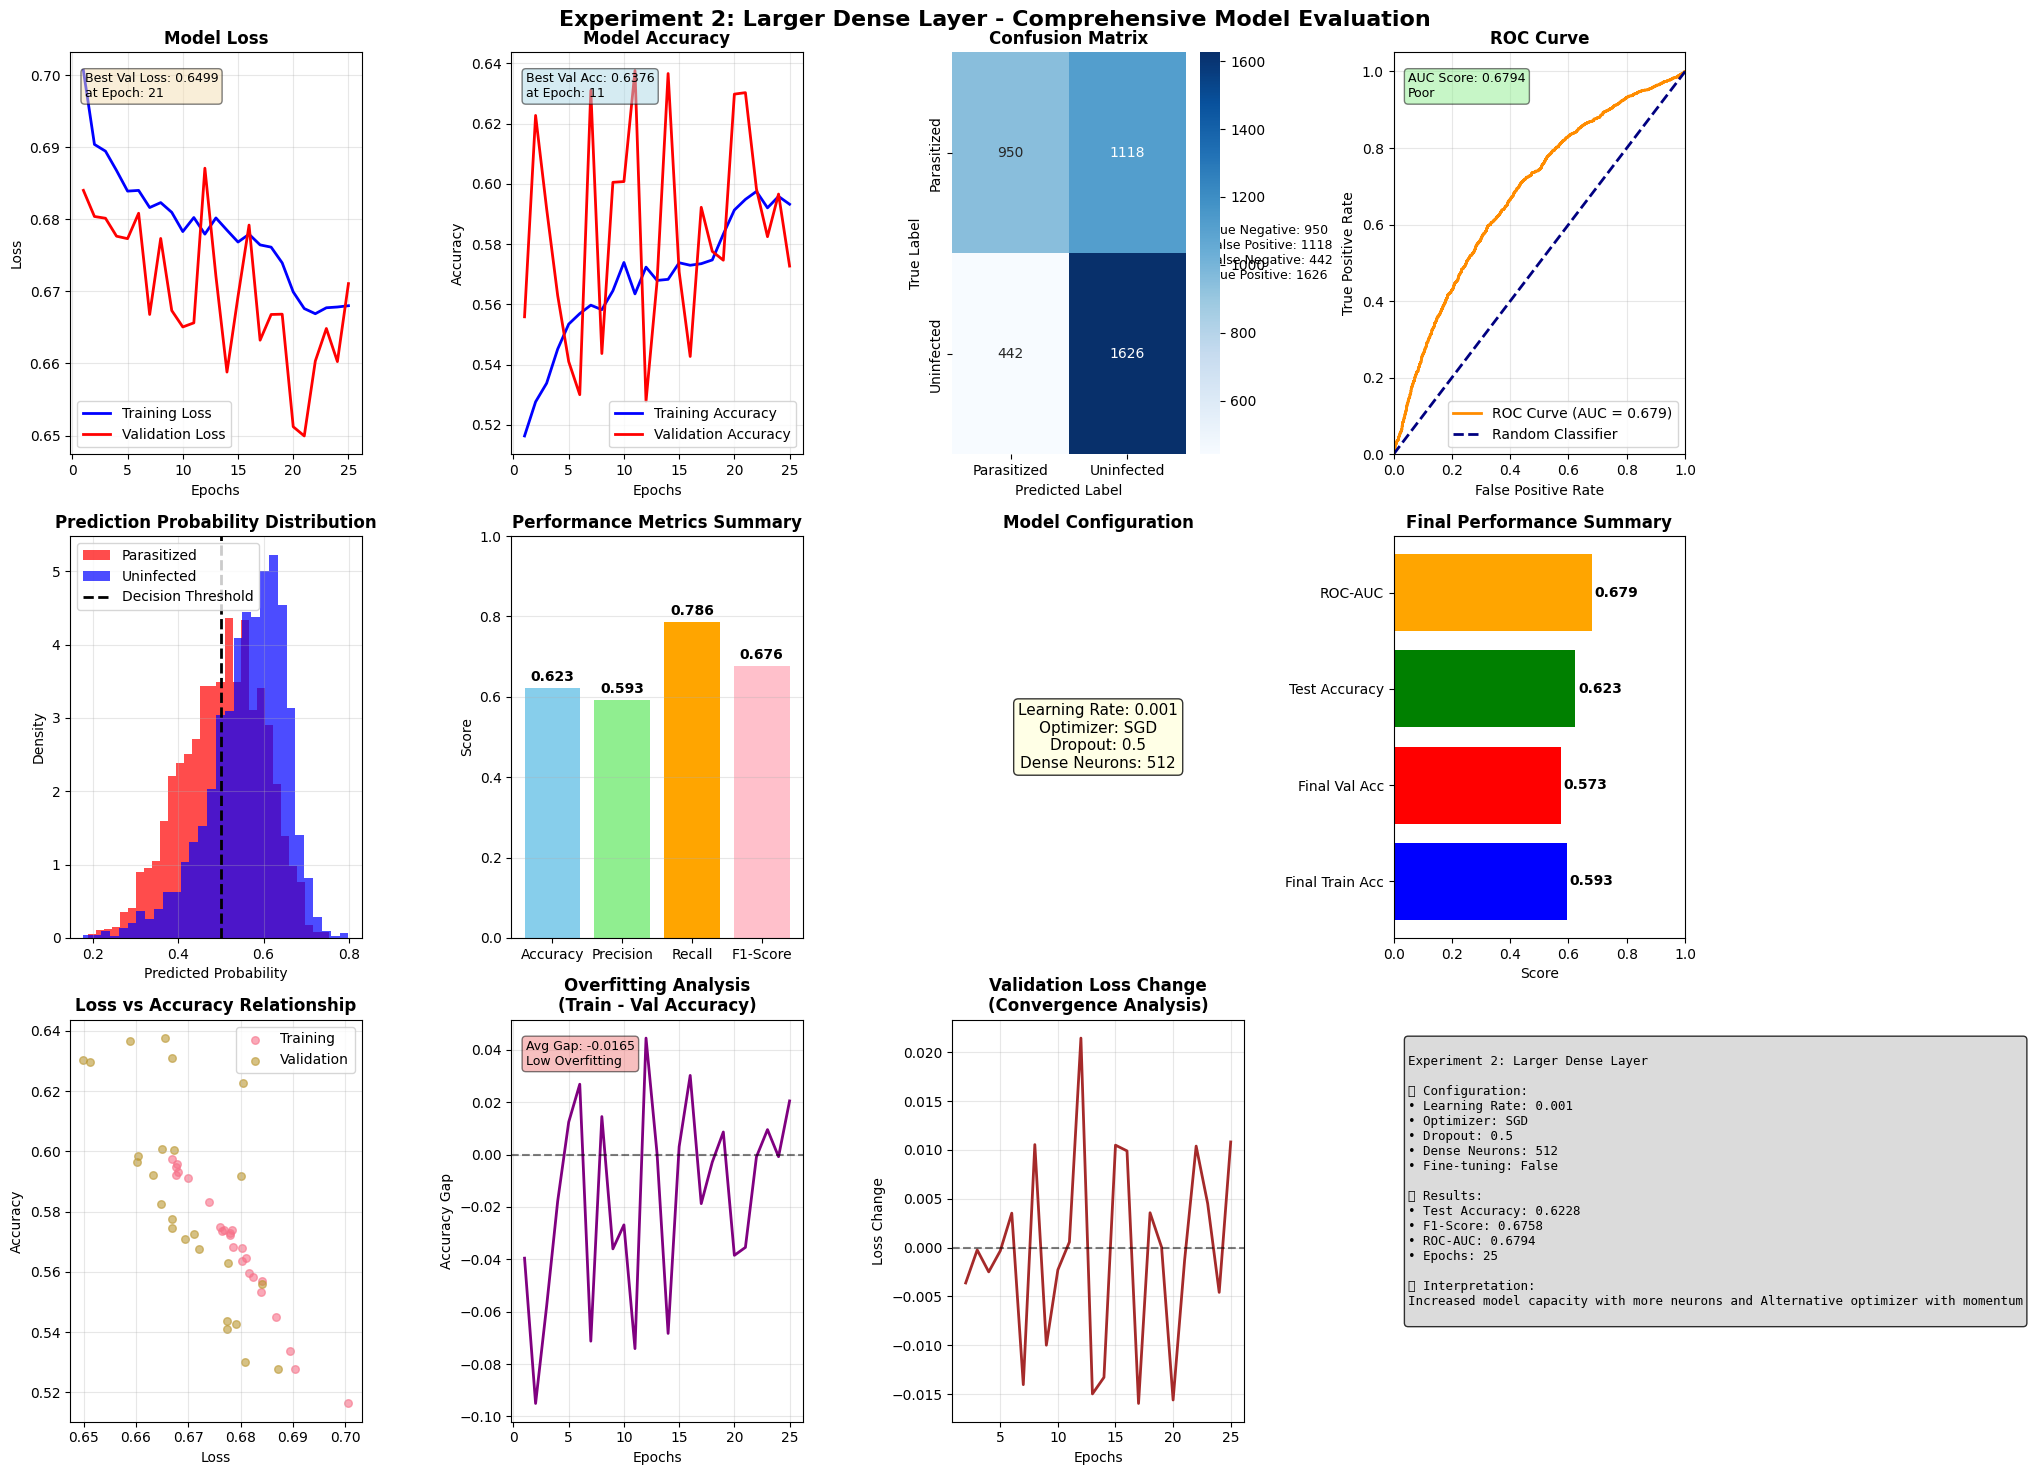


💡 KEY INSIGHTS FOR Experiment 2: Larger Dense Layer:
   • Model achieved 62.3% test accuracy
   • Low overfitting detected (gap: -0.0165)
   • ROC-AUC of 0.6794 indicates fair discrimination
   • Best validation accuracy: 0.6376 at epoch 11

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Parasitized     0.6825    0.4594    0.5491      2068
  Uninfected     0.5926    0.7863    0.6758      2068

    accuracy                         0.6228      4136
   macro avg     0.6375    0.6228    0.6125      4136
weighted avg     0.6375    0.6228    0.6125      4136


 EXPERIMENT 2 SUMMARY:
   Test Accuracy: 0.6228
   F1-Score: 0.6758
   ROC-AUC: 0.6794
   Training Time: 21.49 minutes

📈 CURRENT RANKINGS (by F1-Score):
   1. Experiment 1: Lower Learning Rate - F1: 0.6900
   2. Experiment 2: Larger Dense Layer - F1: 0.6758

⏱️  Progress: 2/3 | Estimated time remaining: 19.8 minutes

EXPERIMENT 3/3: Experiment 3: Fine-tuned ResNet50
📝 Description: Unfrozen t

In [ ]:
# 🎯 START ALL EXPERIMENTS
# Run this cell to execute all 7 experiments and get comprehensive analysis

# Uncomment the line below when you're ready to start training:
final_results = run_all_experiments()

print("🚀 Ready to start experiments!")
print("📋 Uncomment the line above to begin the experimental suite")
print("⏰ Estimated total time: 2-4 hours (depending on hardware)")
print("🖥️  GPU strongly recommended for faster training")
print("\n📊 The suite will:")
print("   • Train 7 different ResNet50 models")
print("   • Generate comprehensive evaluation plots for each")
print("   • Provide real-time progress updates")
print("   • Create comparative analysis across all experiments")
print("   • Export results to CSV and JSON files")
print("   • Identify the best performing model")